In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

from helper_funcs import load_energy_data, load_temperature, merge_datasets, resample_as_needed

#Prophet version is 0.7.1 at the time of writing
from fbprophet import Prophet 
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

Importing plotly failed. Interactive plots will not work.


## Prophet by Facebook

Directly from the docs:

"Prophet is a procedure for forecasting time series data based on an **additive model** where non-linear trends are fit with **yearly, weekly, and daily seasonality, plus holiday effects**. 
It works best with time series that have **strong seasonal effects and several seasons of historical data**. 
Prophet is robust to missing data and shifts in the trend, and typically handles outliers well."

Link to the documentation: https://facebook.github.io/prophet/docs/quick_start.html
We have found the maintainers to be very active on github and strongly recommend reading through relevant issues. Frequently they contain useful best practices.

### Installing Prophet

Prophet's engine is **Stan**-based and it relies on pystan to run. When installing, it is important to make sure pystan has compiled well.

For non-Conda environments, just follow the instructions in the docs (first, install pystan, then Prophet).

For Conda environment, we have found the following sequence to work well:

1. First install Ephem (helps with pystan compilation):
conda install -c anaconda ephem
2. Install Pystan:
conda install -c conda-forge pystan
3. Finally install Fbprophet
conda install -c conda-forge fbprophet

When you are running a Jupyter Notebook or JupyterLab, if you run into "fbprophet not found" errors when importing, make sure you have jupyter notebook installed in your environment. You can do so by running *conda install -c anaconda notebook*.


## Data Load

Prophet expects the data in a particular format:
- The data needs to be in a pandas DataFrame with **column "ds" containing the time component and column "y" containing the target variable.**
- Any additional variables of interest can be added as a separate column. One needs to make sure to add them to both the train data and the DataFrame used to produce the forecast.

In [2]:
# Data Load
energy = load_energy_data("../data/") # Load the energy consumption data
temp = load_temperature('../data/avg_temp.csv') # Load the temperature data
final_df = merge_datasets(energy, temp)
print(final_df.info())
print(final_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52614 entries, 0 to 52613
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   time      52614 non-null  datetime64[ns]
 1   actuals   52546 non-null  float64       
 2   avg_temp  52614 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.6 MB
None
                 time  actuals  avg_temp
0 2015-01-01 00:00:00   5024.0      -9.7
1 2015-01-01 01:00:00   4773.0      -9.7
2 2015-01-01 02:00:00   4585.0      -9.7
3 2015-01-01 03:00:00   4440.0      -9.7
4 2015-01-01 04:00:00   4418.0      -9.7


The data used represents hourly energy consumption in Bulgaria and daily temperature in Sofia.

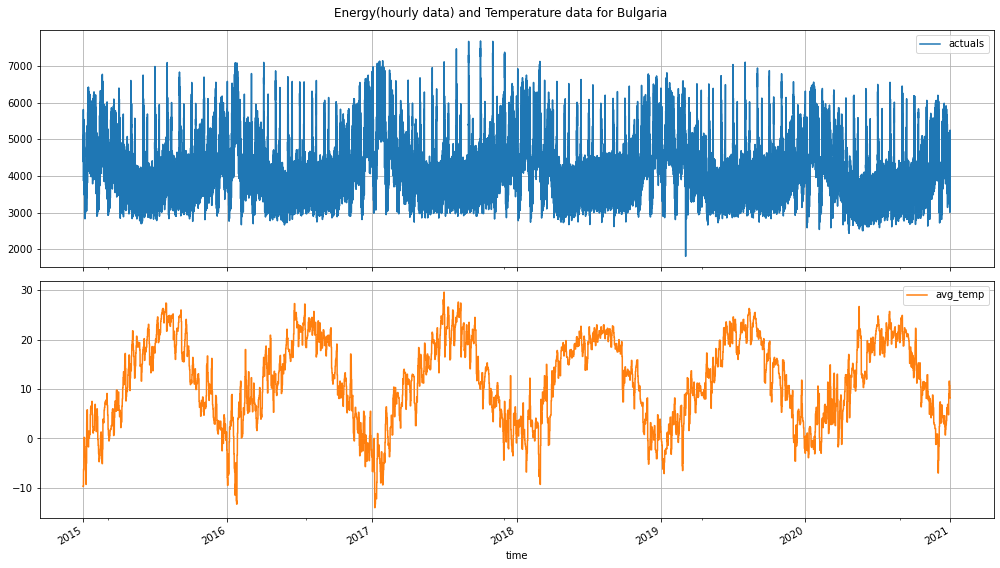

In [3]:
(final_df.
 set_index('time').
 plot(subplots=True, figsize=(14,8), grid=True))

plt.suptitle('Energy(hourly data) and Temperature data for Bulgaria')
plt.tight_layout()
plt.show()

As the energy data is on an hourly frequency, we can use the *resample_as_needed* function from the helpers to resample the data on a daily average level.

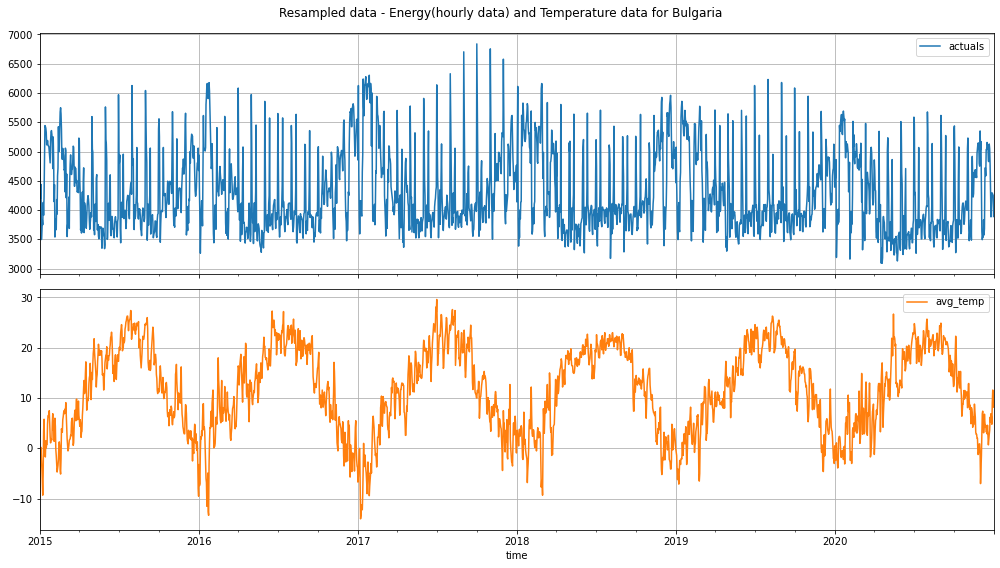

In [4]:
(final_df.
 pipe(resample_as_needed, freq='D').
 plot(subplots=True, figsize=(14,8), grid=True))

plt.suptitle('Resampled data - Energy(hourly data) and Temperature data for Bulgaria')
plt.tight_layout()
plt.show()

Let us prepare the data in the Prophet format

In [5]:
prophet_time_series = final_df.copy()

## Renaming so that the format fits Prophet's requirements
prophet_time_series = prophet_time_series.rename({'time':'ds', 'actuals':'y'}, axis=1)

## Set asside 2020 data to validate the results.
train_set_prophet = prophet_time_series.loc[lambda df: df['ds']< pd.to_datetime('2020-01-01')]
test_set_prophet = prophet_time_series.loc[lambda df: df['ds']>= pd.to_datetime('2020-01-01')]

### Modelling

Prophet follows a scikit-learn like API. A Model object is created and data is fitted. 
Then, a future DataFrame is created - just a pandas DataFrame containing one column "ds" - the future periods to be forecasted. 
Lastly, the fitted model object is used to predict and predictions are stored in a forecast object.

Important note - the forecast dataframe stores by default in the yhat column both the forecast and the fitted yhat for the past, training data. However, the fitted yhat is not equal the train data - it is just the fit of it, and customers/users might be confused. 

The forecast dataframe contains a number of useful details:
- Lower and Upper Confidence Intervals
- Breakdown of components - trend, seasonal effects
- The effect of any holidays or additional regressors added to the model

In [6]:
#As we are fitting an hourly data, this cell takes roughly 10 min to complete
m = Prophet()
m.fit(train_set_prophet)

#Frequency is daily by default in the make_future_dataframe
future = m.make_future_dataframe(periods=365 ) #If you do not want to include the past, use include_history=False
forecast = m.predict(future)

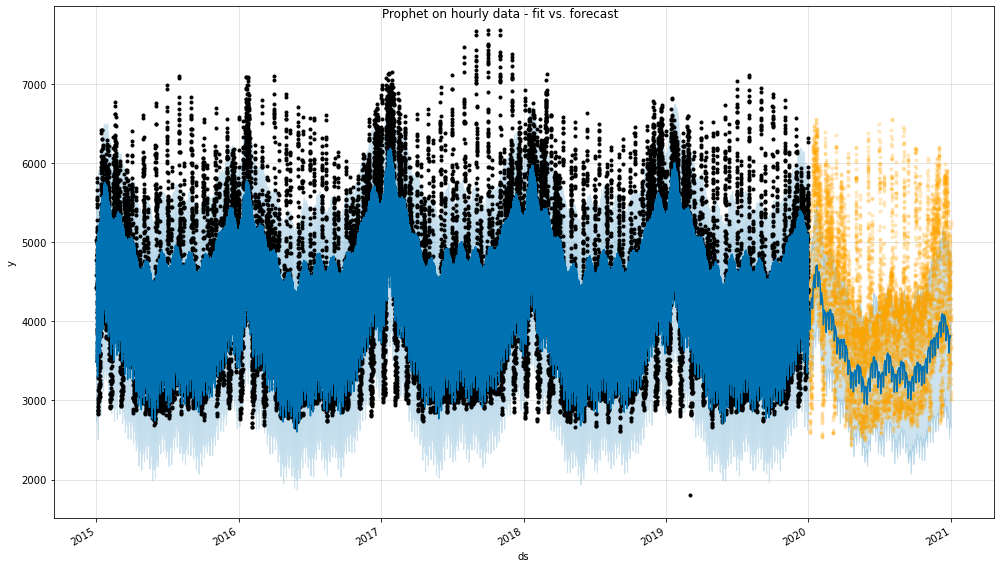

In [7]:
#Plot fit and forecast
fig, ax = plt.subplots(figsize=(14,8))
test_set_prophet.set_index('ds').y.plot(ax=ax, style = ".", color='orange', alpha=0.2)
m.plot(forecast, ax=ax)
plt.suptitle('Prophet on hourly data - fit vs. forecast')
plt.show()

A very useful function is the plot_components one, decomposing the model into trend and seasonal components. 

When the model is additive, the component impact can be summed up and is very easy to interpret. When the model is multiplicative, the trend needs to be multiplied by the impact of each seasonal component.

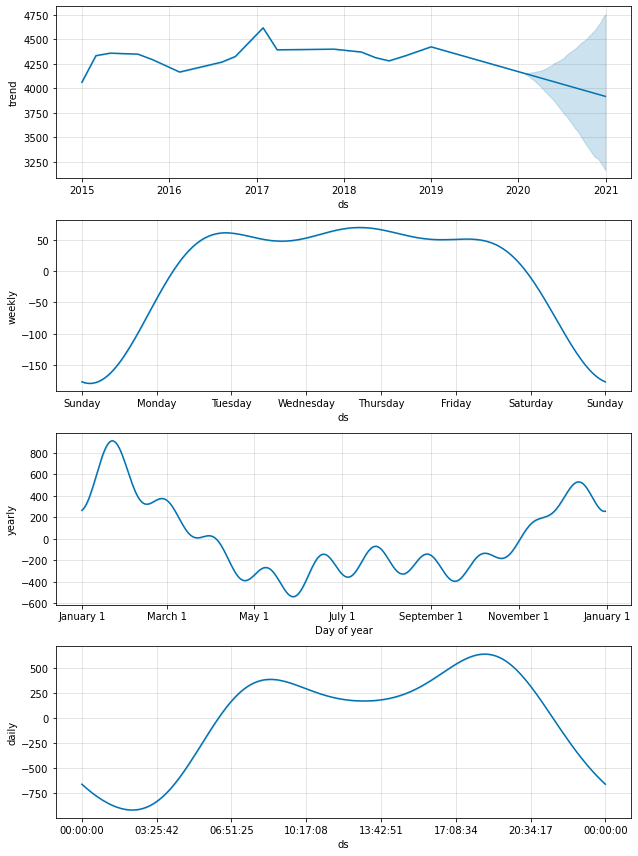

In [8]:
#Plot the breakdown of components
m.plot_components(forecast);

The 'forecast' dataframe contains the values of the components, broken down per down. It will prove a useful analytical tool

In [9]:
print('Components', forecast.columns)
print(forecast.head())
print(forecast.tail())

Components Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')
                   ds        trend   yhat_lower   yhat_upper  trend_lower  \
0 2015-01-01 00:00:00  4062.043562  3008.280142  4493.227412  4062.043562   
1 2015-01-01 01:00:00  4062.237257  2838.910274  4298.200054  4062.237257   
2 2015-01-01 02:00:00  4062.430952  2733.920142  4224.841486  4062.430952   
3 2015-01-01 03:00:00  4062.624647  2733.810445  4298.125076  4062.624647   
4 2015-01-01 04:00:00  4062.818342  2923.162670  4444.210892  4062.818342   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  4062.043562     -331.19695

### Prophet with daily data

In [10]:
#Resampling to get the daily mean
prophet_time_series = final_df.pipe(resample_as_needed).reset_index()
prophet_time_series = prophet_time_series.rename({'time':'ds', 'actuals':'y'}, axis=1)

train_set_prophet = prophet_time_series.loc[lambda df: df['ds'] < pd.to_datetime('2020-01-01')]
test_set_prophet = prophet_time_series.loc[lambda df: df['ds'] >= pd.to_datetime('2020-01-01')]

In [11]:
m = Prophet()
m.fit(train_set_prophet)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


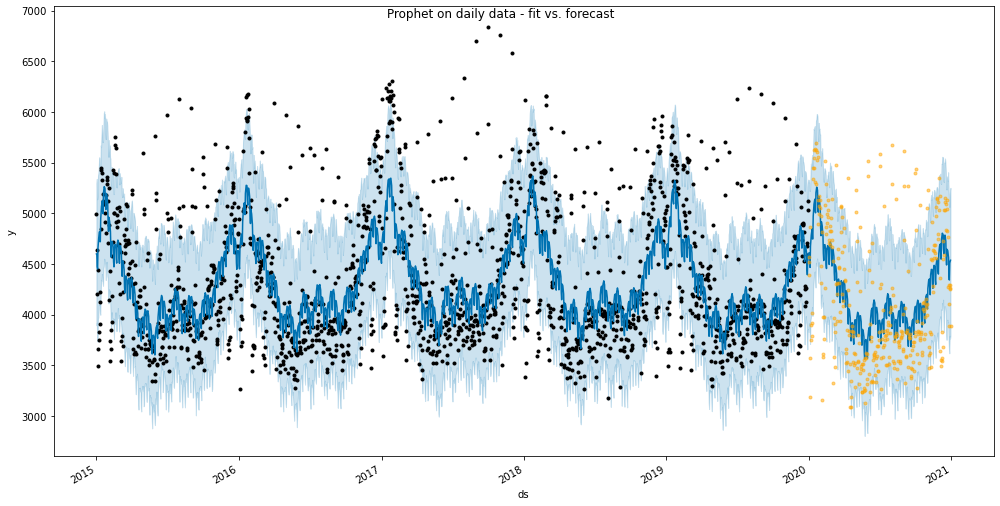

In [12]:
#Plot fit and forecast
fig, ax = plt.subplots(figsize=(14,8))
m.plot(forecast, ax=ax)
test_set_prophet.set_index('ds').y.plot(ax=ax, style = ".", color='orange', alpha=0.5)
plt.suptitle('Prophet on daily data - fit vs. forecast')
plt.show()

#### Be careful with the plots out of the plot_components function - trends might seem steeper than they are. Always look for the y-axis to assess the actual impact.

In our case, the drop in trends is from a peak in 2017 of 4400 GGwats to forcast of ca. 4200 - less than 5% drop, but the plot makes it seem bigger.

The weekly seasonality is strong - with energy consumption dropping 150 points on Sundays. 
Even stronger is the yearly seasonality, with peaks in the winter months and a low point in June, before the cooling requirements peak.

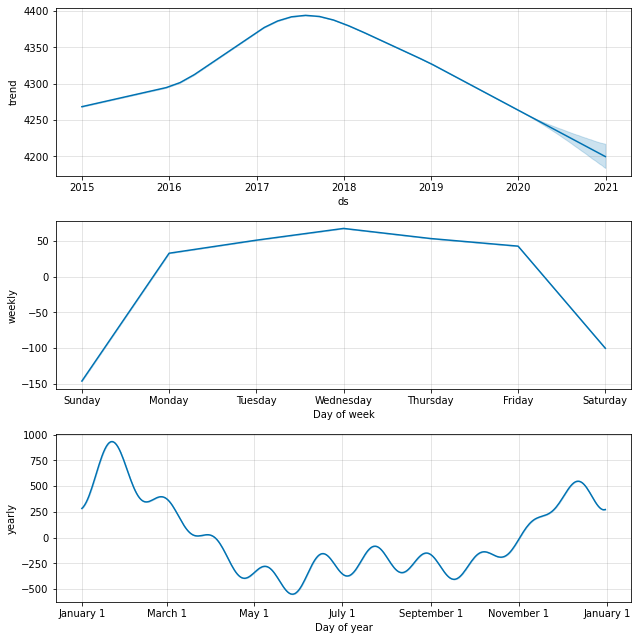

In [13]:
m.plot_components(forecast);

#### Public holidays

Prophet enables a very easy addition of public holidays, by using the **add_country_holiday** method. The package uses the *holidays* package as source. 

The holidays effects can be adjusted by using the holidays_prior_scale (default=10). Reducing it decreases the holidays effects.

In addition, you can create special events for a given process and add them as to the model. For a detailed explanation, please check the documentation here - https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#modeling-holidays-and-special-events

In [14]:
m = Prophet(holidays_prior_scale=10) #Using the defaults
m.add_country_holidays('BG') # Adding holidays for Bulgaria
m.fit(train_set_prophet)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


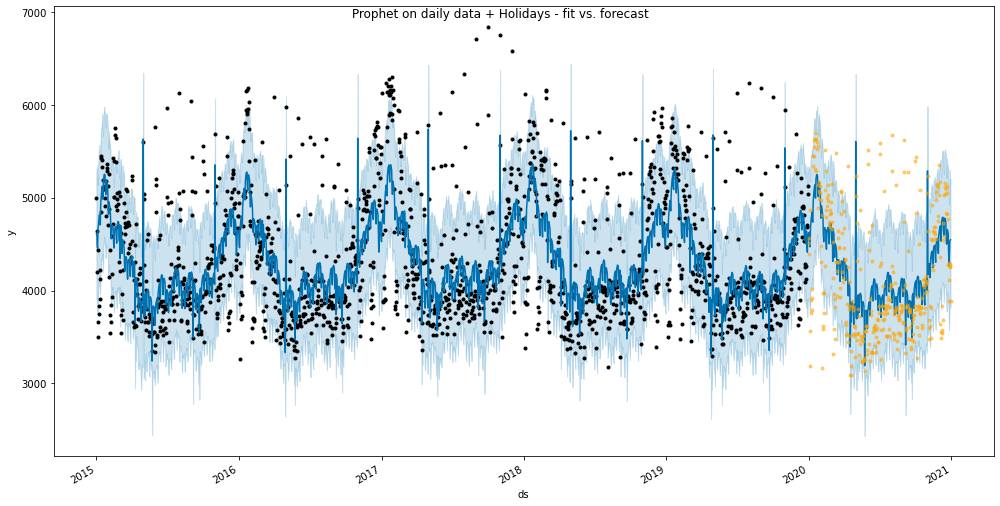

In [15]:
#Plot fit and forecast
fig, ax = plt.subplots(figsize=(14,8))
m.plot(forecast, ax=ax)
test_set_prophet.set_index('ds').y.plot(ax=ax, style = ".", color='orange', alpha=0.5)
plt.suptitle('Prophet on daily data + Holidays - fit vs. forecast')
plt.show()

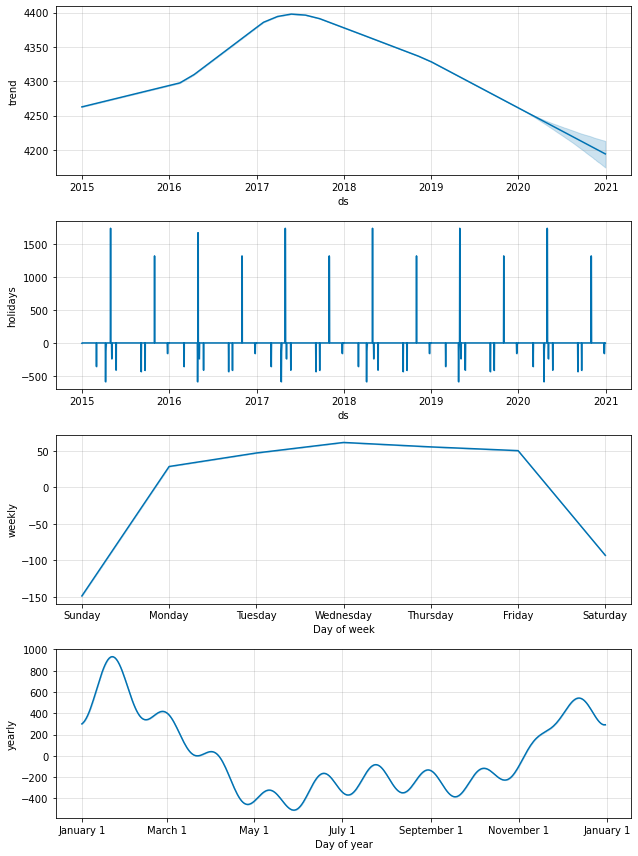

In [16]:
#Plot the breakdown of components - notice the strong holidays effect
m.plot_components(forecast);

As the forecast dataframe contains the impact of each holiday, we can explore the impact of each one

<AxesSubplot:>

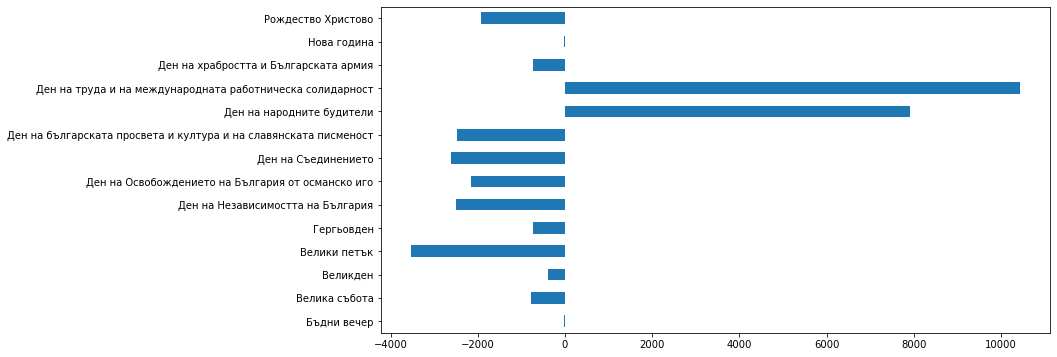

In [17]:
bg_holidays = forecast.columns[ 18:-4]
#Remove the upper and lower conf intervals
holidays_impact = [h for h in bg_holidays if ("_upper" not in h) and ('_lower' not in h)]

forecast.loc[:,holidays_impact].sum().plot.barh(figsize=(12,6))

#### Changepoints and changepoint_prior_scale

Changepoints in Prophet manage the flexibility of the trend. 

The best way to increase the sensibility of the trend to shifts is to **increase the changepoint_prior_scale**. The default is 0.05, usual range to test is between 0.001 (mostly focused on the longterm trend) and 0.5 (super sensitive to changes). In other words, if you aim to increase the short-term sensitivity of the model, setting the changepoint_prior_scale high makes sense. The price to pay is more eratic long-term trend.

Another way to impact trend sensitivity is to increase the default number of max changepoints from 25. The maintainers of Prophet recommend this approach only in cases of time series with many shifts in overall trend.

If you know the changepoints of a process in advance, those can be specified by using the changepoints argument in the Prophet class.

Lets Compare the impact of setting **changepoint_prior_scale** high and low

In [18]:
m = Prophet(changepoint_prior_scale=0.5, n_changepoints=40)
m.add_country_holidays('BG')
m.fit(train_set_prophet)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


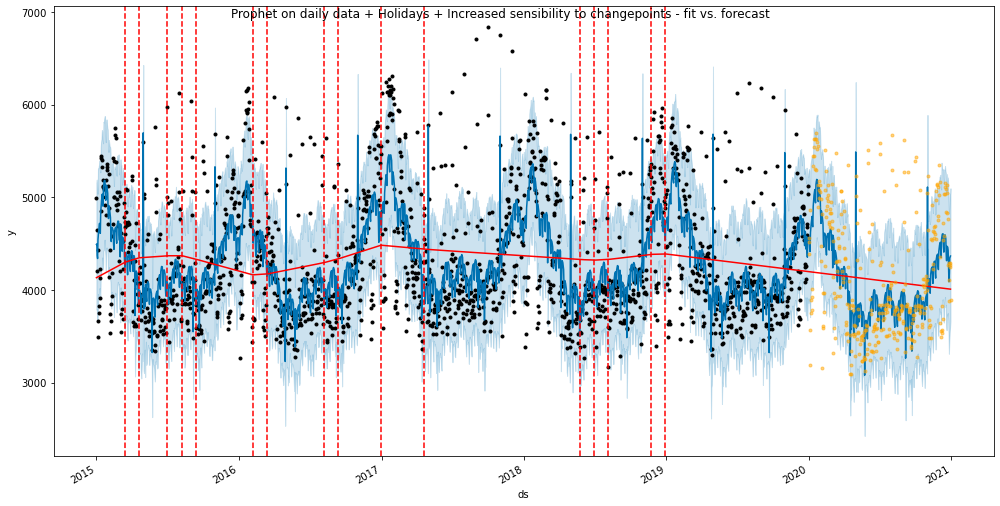

In [19]:
from fbprophet.plot import add_changepoints_to_plot

fig, ax = plt.subplots(figsize=(14,8))
m.plot(forecast, ax=ax)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
test_set_prophet.set_index('ds').y.plot(ax=ax, style = ".", color='orange', alpha=0.5)
plt.suptitle('Prophet on daily data + Holidays + Increased sensibility to changepoints - fit vs. forecast')
plt.show()

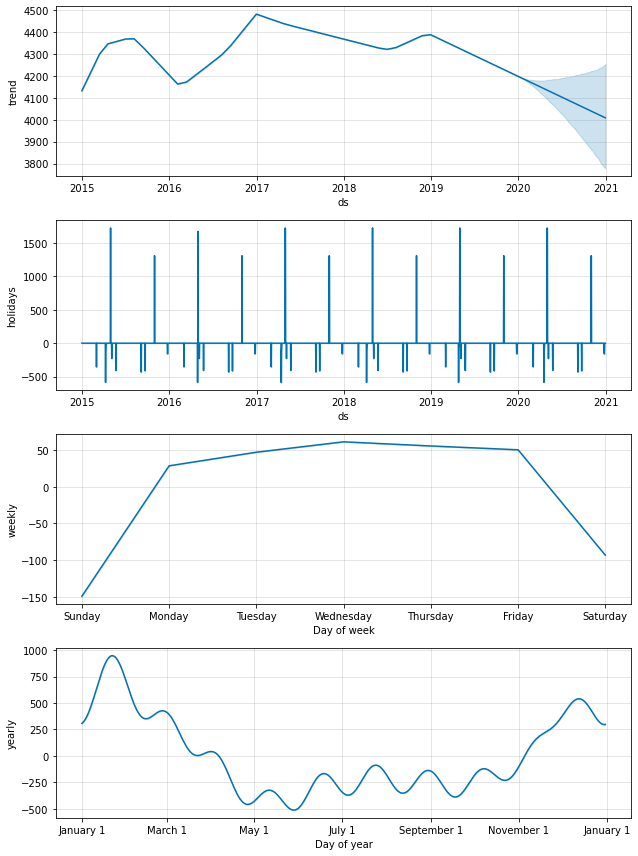

In [20]:
m.plot_components(forecast);

Now lets set it very low.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


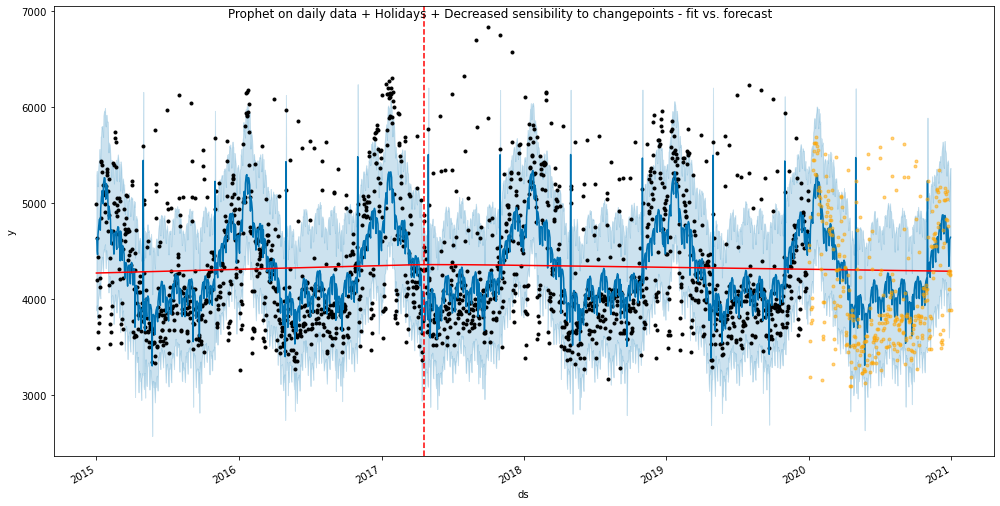

In [21]:
m = Prophet(changepoint_prior_scale=0.01, n_changepoints=40)
m.add_country_holidays('BG')
m.fit(train_set_prophet)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

fig, ax = plt.subplots(figsize=(14,8))
m.plot(forecast, ax=ax)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
test_set_prophet.set_index('ds').y.plot(ax=ax, style = ".", color='orange', alpha=0.5)
plt.suptitle('Prophet on daily data + Holidays + Decreased sensibility to changepoints - fit vs. forecast')
plt.show()

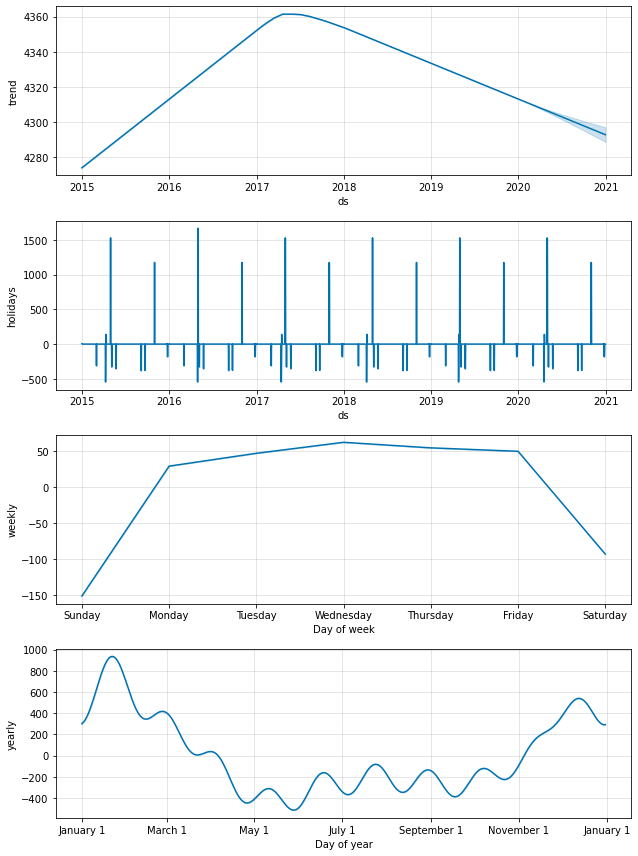

In [22]:
m.plot_components(forecast);

By default Prophet takes only the first 80% of the train data into account when assigning changepoints. This is done to avoid overfitting to latest changes but is rather conservative. Changing it to 90% or even 95% makes sense in some cases.

Lets change it to changepoint_range=0.95 and check the impact

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


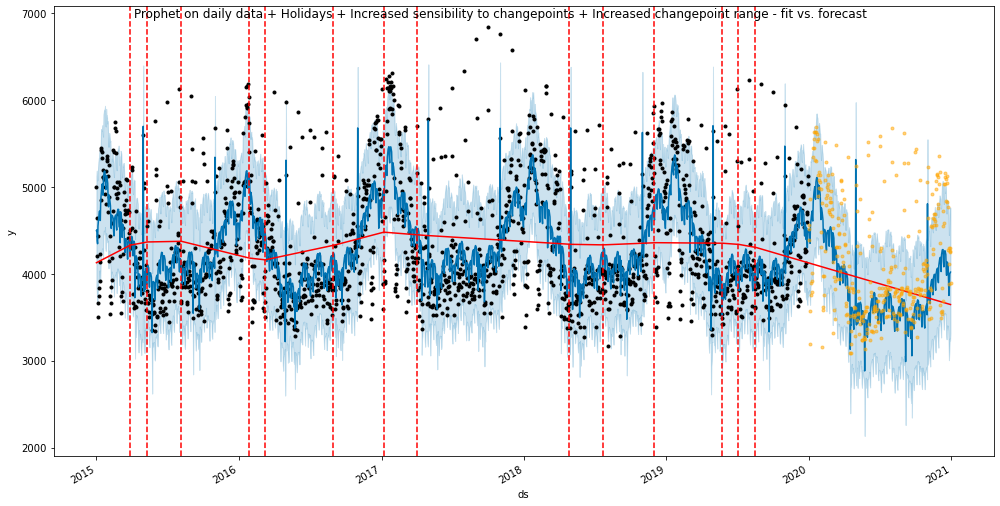

In [23]:
m = Prophet(changepoint_prior_scale=0.5, n_changepoints=40, changepoint_range=0.95)
m.add_country_holidays('BG')
m.fit(train_set_prophet)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

fig, ax = plt.subplots(figsize=(14,8))
m.plot(forecast, ax=ax)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
test_set_prophet.set_index('ds').y.plot(ax=ax, style = ".", color='orange', alpha=0.5)
plt.suptitle('Prophet on daily data + Holidays + Increased sensibility to changepoints + Increased changepoint range - fit vs. forecast')
plt.show()

#### Seasonal impact

The effect of the daily, weekly and yearly seasonality in Prophet is controlled by the **seasonality_priod_scale**. 

The default is 10, values to test are usually from 0.01 to 10. Reducing it decreases the seasonal effects.


In [24]:
m = Prophet(seasonality_prior_scale=0.01)
m.add_country_holidays('BG')
m.fit(train_set_prophet)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


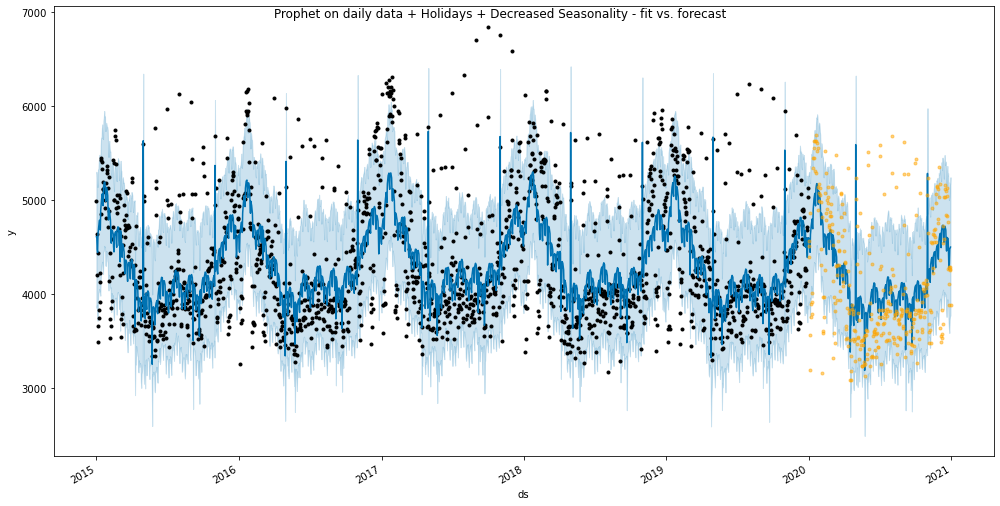

In [25]:
#Plot fit and forecast
fig, ax = plt.subplots(figsize=(14,8))
m.plot(forecast, ax=ax)
test_set_prophet.set_index('ds').y.plot(ax=ax, style = ".", color='orange', alpha=0.5)
plt.suptitle('Prophet on daily data + Holidays + Decreased Seasonality - fit vs. forecast')
plt.show()

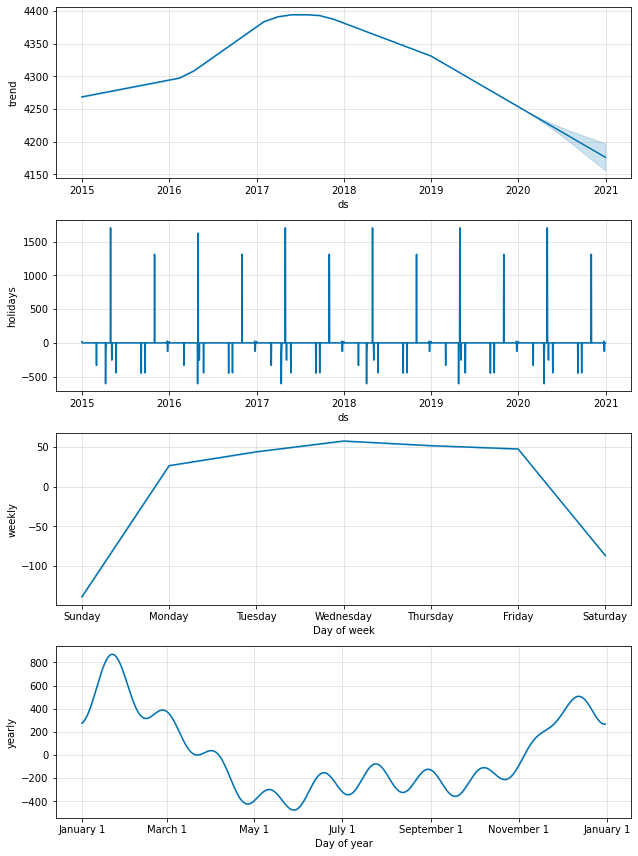

In [26]:
m.plot_components(forecast);

In addition, the Fourier order for each individual seasonality can be increased from the default of 10. 

This will change how quickly the seasonality can change and make it more adaptable to changes.

In [27]:
#Increasing the weekly and yearly_seasonality Fourier order
m = Prophet(seasonality_prior_scale=0.01, yearly_seasonality = 12, weekly_seasonality=12) 
m.add_country_holidays('BG')
m.fit(train_set_prophet)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


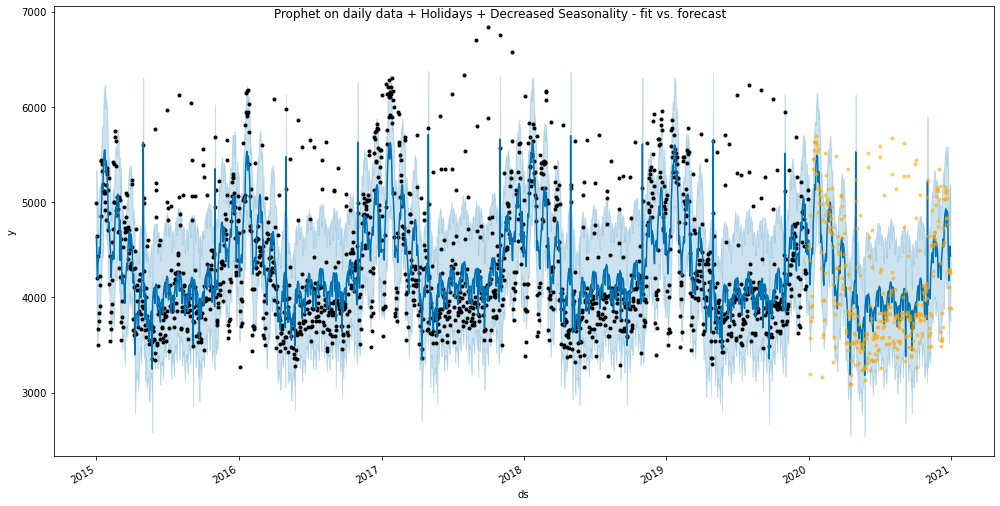

In [28]:
#Plot fit and forecast
fig, ax = plt.subplots(figsize=(14,8))
m.plot(forecast, ax=ax)
test_set_prophet.set_index('ds').y.plot(ax=ax, style = ".", color='orange', alpha=0.5)
plt.suptitle('Prophet on daily data + Holidays + Decreased Seasonality - fit vs. forecast')
plt.show()

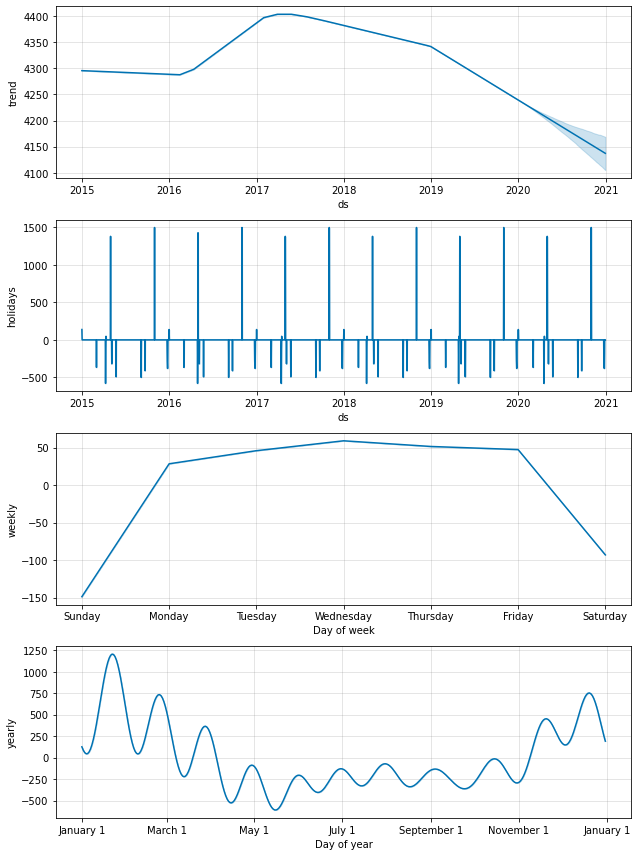

In [29]:
m.plot_components(forecast);

### Cross-validation and Prophet

Documentation reference: https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning

Prophet provides useful functions to perform cross-validation (cross_validation) and estimate metrics (performance_metrics). 

The cross-validation is calculated either based on historical cutoff points, that the used provides or begins from (*end* - *horizon*) and works backwards, making cutoffs with a spacing of period until *initial* is reached. The technique follows https://robjhyndman.com/hyndsight/tscv/ .

The default performance metrics that Prophet calculates are the following:

- 'mse': mean squared error
- 'rmse': root mean squared error
- 'mae': mean absolute error
- 'mape': mean absolute percent error
- 'mdape': median absolute percent error
- 'coverage': coverage of the upper and lower intervals

A subset of these can be specified by passing a list of names as the `metrics` argument.

Metrics are calculated over a rolling window of cross validation predictions, after sorting by horizon. Averaging is first done within each value of horizon, and then across horizons as needed to reach the window size. The size of that window (number of simulated forecast points) is determined by the rolling_window argument, which specifies a proportion of simulated forecast points to include in each window. **rolling_window=0** will compute it separately for each horizon. The default of rolling_window=0.1 will use 10% of the rows in df in each window. rolling_window=1 will compute the metric across all simulated forecast points. 

If rolling_window < 0, then metrics are computed at each datapoint with no averaging (i.e., 'mse' will actually be squared error with no mean).

In [30]:
import itertools
import numpy as np

#Set parameters to test
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'yearly_seasonality': [10, 12],
    'weekly_seasonality': [10, 12],
    'holidays':[True, False]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
coverages = []

#Create 12 cutoff points, three months apart from beginning of 2017.
cutoffs = pd.date_range(start='2017-01-01', periods=12, freq='3M')

# Use cross validation to evaluate all parameters
for params in all_params:
    
    if params['holidays']:
        settings = {x: params[x] for x in params if x not in ['holidays']}
        m = Prophet(**settings) 
        m.add_country_holidays('BG')
        m.fit(train_set_prophet) 
    else:
        settings = {x: params[x] for x in params if x not in ['holidays']}
        m = Prophet(**settings).fit(train_set_prophet)  # Fit model with given params
        
    df_cv = cross_validation(m, cutoffs = cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    print(f'Scoring {params}\n')
    print("Performance metrics:")
    print(df_p)
    rmses.append(df_p['rmse'].values[0])
    coverages.append(df_p['coverage'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results['coverage'] = coverages
print('All results:')
print(tuning_results)

# Get the best params only
best_params = all_params[np.argmin(rmses)]
print("Best params: ",best_params)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239207F16A0>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae     mape     mdape  coverage
0 30 days  369990.055479  608.268079  466.971402  0.10182  0.083534  0.758333


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023962FD4B20>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  379546.871492  616.073755  459.162608  0.099186  0.078008  0.766667


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023921EB6FA0>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse       rmse         mae      mape     mdape  coverage
0 30 days  375766.093826  612.99763  459.836614  0.099428  0.080741  0.755556


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023921EB6FD0>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  389374.778957  623.999022  466.084772  0.100512  0.080451  0.747222


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023960817D60>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  309316.625558  556.162409  405.481203  0.087634  0.070579  0.816667


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023921E80D30>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  320956.503139  566.530231  403.847629  0.086673  0.067608  0.808333


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023960811160>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  310240.067817  556.991982  401.144688  0.086602  0.067269  0.811111


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239602BE730>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse       rmse        mae      mape     mdape  coverage
0 30 days  327878.478126  572.60674  410.95109  0.088063  0.071914  0.808333


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023921E80D90>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  367078.781809  605.870268  448.327259  0.097078  0.076325  0.769444


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023921E8D040>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon           mse        rmse         mae      mape     mdape  coverage
0 30 days  373688.60459  611.300748  452.776452  0.098148  0.077826  0.752778


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023962FBC490>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  369752.199548  608.072528  456.917323  0.099277  0.080389  0.761111


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023921E80FA0>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  380378.335376  616.748194  452.762827  0.097609  0.078514  0.758333


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239607A1940>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  301462.768768  549.056253  391.400164  0.084299  0.066211  0.813889


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002395FF4FDF0>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape    mdape  coverage
0 30 days  308194.609741  555.152781  390.243163  0.083679  0.06371  0.827778


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239608DEAF0>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae     mape    mdape  coverage
0 30 days  304451.790681  551.771502  392.265483  0.08439  0.06375     0.825


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023960865970>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  308813.458154  555.709869  396.743195  0.085545  0.065566     0.825


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239607D11F0>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  367926.421985  606.569388  450.068598  0.097621  0.077357  0.763889


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023920850580>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  374615.318084  612.058264  453.062085  0.098024  0.077796  0.755556


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023920850A00>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon           mse        rmse         mae     mape     mdape  coverage
0 30 days  369252.05939  607.661139  446.451171  0.09641  0.073749  0.752778


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023962FBFFD0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  372602.221396  610.411518  452.480104  0.097983  0.077529  0.763889


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239203D7670>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse       rmse         mae      mape     mdape  coverage
0 30 days  302051.070179  549.59173  389.233293  0.083656  0.066775  0.822222


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002392079FB20>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape    mdape  coverage
0 30 days  310572.763035  557.290555  392.136727  0.083979  0.06128  0.819444


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023962F9C5E0>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  309584.227123  556.402936  398.881788  0.086044  0.068119  0.827778


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002395FF4FDF0>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae     mape     mdape  coverage
0 30 days  312910.243778  559.383807  391.935022  0.08392  0.063314  0.822222


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002396080A670>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  370317.971088  608.537568  449.993909  0.097241  0.076083  0.763889


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023962FAD160>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae     mape     mdape  coverage
0 30 days  373052.309667  610.780083  448.851127  0.09694  0.075513  0.777778


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239607D1160>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  370579.513123  608.752424  446.330302  0.096342  0.074996  0.758333


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239208562E0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  372034.141841  609.946016  451.848595  0.097898  0.078541  0.763889


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023962FBFD30>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse       rmse         mae      mape     mdape  coverage
0 30 days  302909.040752  550.37173  391.315966  0.084071  0.065934  0.819444


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239607D1160>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape    mdape  coverage
0 30 days  308170.978854  555.131497  392.994416  0.084508  0.06034     0.825


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002396BC709D0>


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape    mdape  coverage
0 30 days  312246.883937  558.790555  399.770703  0.086085  0.06932  0.813889


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239607D1160>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse      rmse         mae      mape     mdape  coverage
0 30 days  314000.527964  560.3575  390.571149  0.083444  0.065155     0.825


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239207A5160>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  334522.676149  578.379353  453.957224  0.101034  0.088936  0.788889


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002396080A190>


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape   mdape  coverage
0 30 days  369990.670099  608.268584  476.422276  0.105433  0.0902  0.783333


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239607F80D0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon           mse       rmse         mae      mape     mdape  coverage
0 30 days  333976.68529  577.90716  453.999286  0.101114  0.088252  0.797222


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239203E6220>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape    mdape  coverage
0 30 days  370165.343237  608.412149  475.183856  0.104989  0.09069     0.775


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239207CC280>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon          mse        rmse         mae      mape     mdape  coverage
0 30 days  276992.2805  526.300561  397.817056  0.087937  0.074408  0.833333


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239207F4520>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  310946.587938  557.625849  419.090266  0.092096  0.079436  0.827778


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239608BBF10>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse        rmse        mae      mape     mdape  coverage
0 30 days  277094.666129  526.397821  397.83273  0.087888  0.075089  0.830556


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239207E2AF0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  308934.576993  555.818835  415.412643  0.091189  0.077244  0.819444


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239203E22E0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  331849.505269  576.063803  442.194104  0.098039  0.081496       0.8


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239203E2A30>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon           mse       rmse         mae      mape    mdape  coverage
0 30 days  364223.84901  603.50961  458.808688  0.100949  0.08449  0.780556


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023962F77280>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse        rmse        mae      mape     mdape  coverage
0 30 days  331703.535566  575.937093  442.19871  0.097986  0.082016  0.788889


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239203E67F0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  365200.750957  604.318419  459.356531  0.101003  0.085194  0.783333


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239207CC280>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  271634.771934  521.185928  383.906093  0.084322  0.068062  0.827778


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023921E38EB0>


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  302605.170274  550.095601  399.500352  0.087113  0.069168  0.813889


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002396080BFA0>


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  273583.935862  523.052517  384.514065  0.084434  0.067461  0.841667


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023962F67340>


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  302529.967864  550.027243  400.099501  0.087293  0.069282     0.825


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239203E6B20>


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  331236.828113  575.531779  441.507461  0.097859  0.081097  0.791667


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023921E38EB0>


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  364255.098074  603.535499  457.253863  0.100483  0.083711  0.786111


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023960870130>


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  333917.445221  577.855904  443.048818  0.098025  0.082304  0.794444


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002392085FF40>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  365231.388127  604.343767  459.770491  0.101165  0.083567  0.783333


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023962F9C5E0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  270013.623404  519.628351  385.529153  0.084852  0.068958  0.833333


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023960A9AFD0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  302027.820356  549.570578  399.020045  0.087028  0.068855     0.825


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239207B5B20>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  269118.376517  518.766206  383.152072  0.084225  0.067403  0.838889


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023960A9AFD0>


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  302422.956727  549.929956  399.981559  0.087278  0.069513  0.822222


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239607CD790>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  332107.920787  576.288054  441.183145  0.097583  0.082083  0.797222


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023921EBE490>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  364488.152635  603.728542  458.646373  0.100907  0.083915  0.788889


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023962F6B550>


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  332319.991081  576.472021  441.742324  0.097811  0.081102  0.794444


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023920853970>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  364878.447576  604.051693  459.187121  0.101015  0.083125  0.777778


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023921EB4EB0>


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse        mae      mape     mdape  coverage
0 30 days  271933.471418  521.472407  383.75357  0.084239  0.066551  0.830556


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239607D1160>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  302238.444856  549.762171  399.109313  0.087042  0.068847  0.827778


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023920396DC0>


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  271026.214475  520.601781  382.873403  0.084072  0.066677  0.838889


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023920396DC0>


Scoring {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  302512.096738  550.010997  399.965926  0.087255  0.069399  0.833333


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023921F3FEB0>


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape    mdape  coverage
0 30 days  367514.213726  606.229506  461.886438  0.102215  0.08347  0.761111


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023921EB4E50>


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  401112.660328  633.334556  480.286733  0.105788  0.089263  0.766667


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023960A9AFD0>


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse        rmse        mae      mape     mdape  coverage
0 30 days  366967.840045  605.778706  461.30636  0.102082  0.083404  0.761111


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023920856490>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  401740.283215  633.829854  480.147475  0.105785  0.089305  0.758333


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023962F6BE50>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse        mae      mape     mdape  coverage
0 30 days  305888.120013  553.071532  406.10605  0.089014  0.077817  0.811111


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239203E6340>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape    mdape  coverage
0 30 days  336999.701094  580.516753  423.186735  0.092313  0.08151  0.791667


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023920853070>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  305103.688368  552.361918  404.443746  0.088661  0.077145  0.802778


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239208081F0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae     mape     mdape  coverage
0 30 days  336771.434327  580.320114  423.107832  0.09225  0.081505  0.791667


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023921E80FA0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon           mse        rmse         mae      mape     mdape  coverage
0 30 days  344580.12174  587.009473  438.084149  0.096448  0.074371  0.783333


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023960852520>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape    mdape  coverage
0 30 days  377945.483984  614.772709  456.708029  0.099984  0.07976  0.777778


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002396BC55640>


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  344037.474334  586.547078  438.001248  0.096463  0.074095  0.788889


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002392079FCA0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape    mdape  coverage
0 30 days  379214.152274  615.803664  458.164382  0.100326  0.07986  0.772222


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239600AED60>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse       rmse         mae      mape     mdape  coverage
0 30 days  283339.968449  532.29688  382.513509  0.083398  0.062434  0.816667


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023962F77760>


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape    mdape  coverage
0 30 days  314989.245085  561.239027  401.159864  0.086948  0.06888  0.808333


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239608DE820>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  283031.420595  532.006974  381.984287  0.083265  0.063115  0.816667


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239608DE820>


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse       rmse        mae      mape     mdape  coverage
0 30 days  315608.722951  561.79064  402.01646  0.087211  0.069394  0.808333


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239207E2AF0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon           mse        rmse         mae      mape     mdape  coverage
0 30 days  344099.40425  586.599867  438.655668  0.096599  0.074226  0.783333


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239207A5700>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  377916.876272  614.749442  455.374679  0.099617  0.078134  0.777778


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023962FADEE0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  344154.622053  586.646931  437.604954  0.096318  0.073067  0.780556


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023921E3B670>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  378853.598948  615.510844  457.869725  0.100284  0.079384  0.783333


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023962FC4790>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape    mdape  coverage
0 30 days  282920.616838  531.902826  381.948155  0.083272  0.06257  0.816667


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002396080AF40>


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  314718.472071  560.997747  401.522724  0.087074  0.069135  0.811111


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239600AED60>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  282847.959598  531.834523  382.107484  0.083312  0.062909  0.816667


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023921E747C0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  314770.093878  561.043754  400.290491  0.086762  0.069625  0.816667


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023921F3F520>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae     mape     mdape  coverage
0 30 days  344311.263303  586.780422  437.452417  0.09627  0.073003  0.780556


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239607A2040>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  378550.936392  615.264932  455.494684  0.099601  0.077973  0.780556


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023960811370>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  344272.467708  586.747363  437.509169  0.096306  0.073343  0.777778


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023920856190>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  378338.965256  615.092648  456.982918  0.100057  0.078073  0.772222


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023960846790>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  282468.204477  531.477379  381.951988  0.083268  0.062984  0.822222


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002396BC55820>


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  314422.515072  560.733908  401.995449  0.087227  0.069534  0.816667


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023921F37FA0>


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon          mse        rmse         mae      mape     mdape  coverage
0 30 days  282905.7518  531.888853  381.862566  0.083215  0.063243  0.813889


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002396080BAC0>


Scoring {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  314617.084375  560.907376  401.382298  0.087037  0.069532  0.811111


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239607A23A0>


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  405213.037024  636.563459  477.238636  0.106068  0.085587  0.763889


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023962FC4AC0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse      rmse         mae      mape     mdape  coverage
0 30 days  440655.796921  663.8191  495.380211  0.109378  0.086819  0.738889


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023921EB6FA0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon           mse        rmse         mae      mape     mdape  coverage
0 30 days  404976.89061  636.377946  476.394341  0.105813  0.085214  0.755556


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002396080B040>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  442223.270141  664.998699  495.954303  0.109568  0.086676  0.752778


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002392084D400>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  339554.042257  582.712658  426.963624  0.093917  0.070895  0.786111


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023921E38D90>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  374268.852759  611.775165  445.793999  0.097409  0.073122  0.783333


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023921E3B940>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  340329.965059  583.378064  427.543326  0.093965  0.071234  0.791667


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239203D75E0>


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  375027.638997  612.395002  445.613792  0.097374  0.072365  0.786111


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239208560D0>


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  354049.971559  595.020984  425.659479  0.093083  0.067584  0.783333


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023962FAD610>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  389032.356548  623.724584  441.774118  0.095881  0.066709  0.777778


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023960095730>


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  351882.299041  593.196678  423.572882  0.092732  0.066037  0.794444


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023962FAD610>


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  387536.805154  622.524542  439.602488  0.095413  0.066948  0.786111


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023960852280>


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  292780.622882  541.092065  377.871749  0.081701  0.058688  0.805556


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239207B2E20>


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  327052.104508  571.884695  395.149776  0.084759  0.061753       0.8


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239207A59A0>


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse        rmse        mae      mape    mdape  coverage
0 30 days  291839.615672  540.221821  377.14372  0.081562  0.05845  0.805556


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002396080AF70>


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  326000.587285  570.964611  394.615098  0.084669  0.059456  0.797222


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002396BC55640>


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  350847.540856  592.323848  422.003554  0.092384  0.064546  0.788889


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002395FF32D90>


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  388735.314784  623.486419  441.518675  0.095776  0.066809  0.769444


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002395F0F0C40>


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse       rmse         mae      mape     mdape  coverage
0 30 days  351830.730711  593.15321  423.823747  0.092724  0.066381  0.786111


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239207CCFA0>


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  388755.149692  623.502325  440.994158  0.095679  0.066473  0.783333


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239207A59A0>


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  290812.257465  539.270115  376.811189  0.081525  0.058312  0.816667


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239207F4DF0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon           mse        rmse         mae      mape     mdape  coverage
0 30 days  325247.72995  570.304945  394.726214  0.084761  0.059287  0.797222


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023962FBF430>


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon           mse        rmse         mae      mape    mdape  coverage
0 30 days  291141.44303  539.575243  376.706679  0.081455  0.05843  0.808333


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023962FAD850>


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  325342.438028  570.387971  394.318516  0.084634  0.057909  0.805556


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023921E3B940>


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  352306.620024  593.554227  424.068258  0.092803  0.066973  0.791667


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023962FAACA0>


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 10, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  388414.531017  623.229116  440.795411  0.095651  0.066332     0.775


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002395F0F0C40>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon           mse        rmse         mae      mape     mdape  coverage
0 30 days  350894.95877  592.363874  423.873367  0.092808  0.066313  0.808333


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002396087E610>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 10, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae     mape     mdape  coverage
0 30 days  388257.873446  623.103421  440.116419  0.09542  0.065502  0.794444


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023962FF7E50>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': True}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  292010.762896  540.380202  377.573324  0.081634  0.059045  0.805556


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023921F39BB0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'holidays': False}

Performance metrics:
  horizon            mse        rmse         mae      mape     mdape  coverage
0 30 days  326628.850071  571.514523  395.151605  0.084774  0.061269  0.805556


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002396087E280>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': True}

Performance metrics:
  horizon            mse        rmse      mae      mape     mdape  coverage
0 30 days  291471.129292  539.880662  376.588  0.081408  0.058218  0.805556


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000239207A5370>


Scoring {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 12, 'weekly_seasonality': 12, 'holidays': False}

Performance metrics:
  horizon            mse       rmse         mae      mape     mdape  coverage
0 30 days  326514.862442  571.41479  395.037975  0.084757  0.060739  0.808333
All results:
     changepoint_prior_scale  seasonality_prior_scale  yearly_seasonality  \
0                      0.001                     0.01                  10   
1                      0.001                     0.01                  10   
2                      0.001                     0.01                  10   
3                      0.001                     0.01                  10   
4                      0.001                     0.01                  12   
..                       ...                      ...                 ...   
123                    0.500                    10.00                  10   
124                    0.500                    

Lets use the parameters that we have found.

In [31]:
m_cv = Prophet(
    seasonality_prior_scale=best_params['seasonality_prior_scale'], 
    changepoint_prior_scale = best_params['changepoint_prior_scale'],
    yearly_seasonality = best_params['yearly_seasonality'],
    weekly_seasonality = best_params['weekly_seasonality']

)
m_cv.add_country_holidays('BG')
m_cv.fit(train_set_prophet)

future = m_cv.make_future_dataframe(periods=365)
forecast_cv = m_cv.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


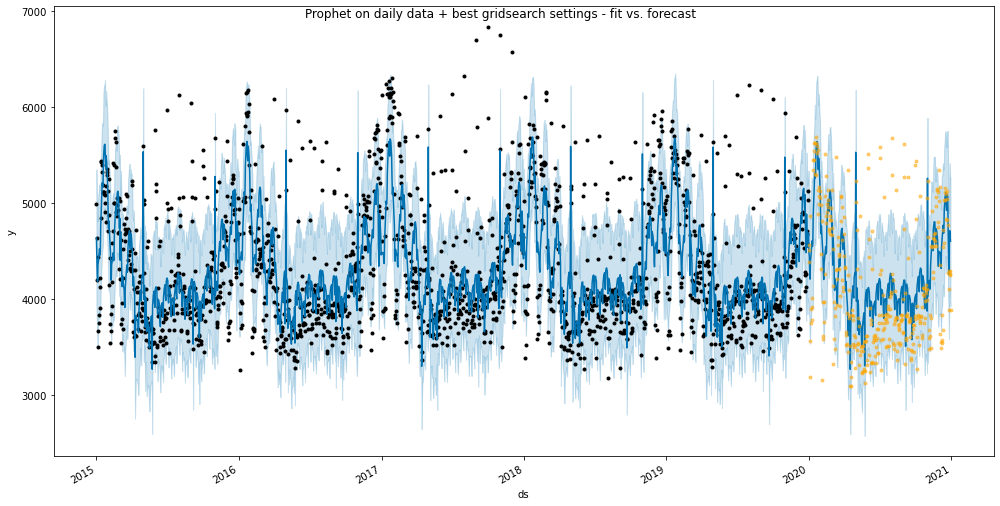

In [32]:
#Plot fit and forecast
fig, ax = plt.subplots(figsize=(14,8))
m_cv.plot(forecast_cv, ax=ax)
test_set_prophet.set_index('ds').y.plot(ax=ax, style = ".", color='orange', alpha=0.5)
plt.suptitle('Prophet on daily data + best gridsearch settings - fit vs. forecast')
plt.show()

In [33]:
cutoffs = pd.date_range(start='2017-01-01', periods=12, freq='3M')
df_cv = cross_validation(m_cv, cutoffs = cutoffs, horizon='30 days', parallel="processes")
df_p = performance_metrics(df_cv, rolling_window=1)
print(f"Cross-Validation RMSE: {df_p.loc[0,'rmse']}")
print(f"Cross-Validation MAPE: {df_p.loc[0,'mape']}")

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023962FC45B0>


Cross-Validation RMSE: 518.7662060282487
Cross-Validation MAPE: 0.08422484494030047


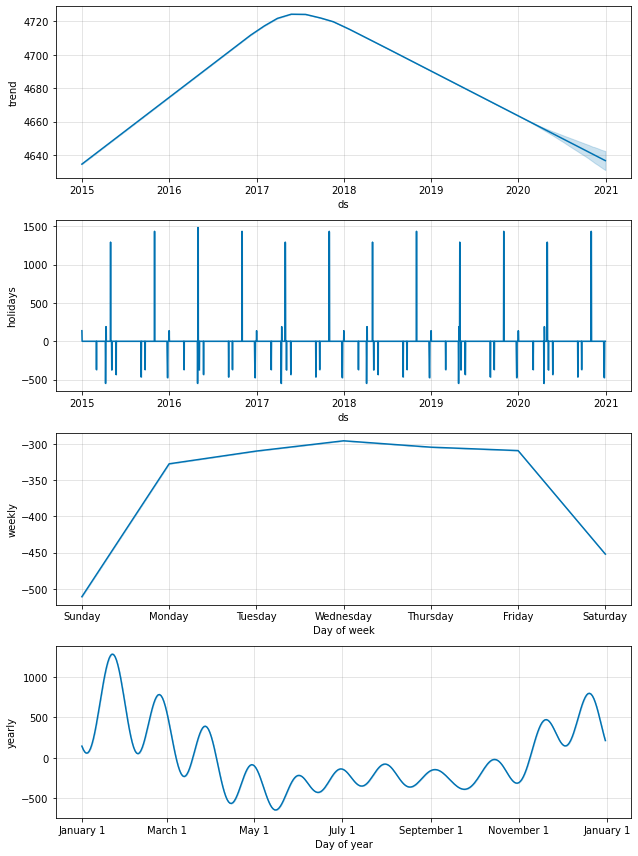

In [34]:
m_cv.plot_components(forecast_cv);

#### Further error analysis and additional regressors

Just for fun, let us analyze the errors that the model does.

In [35]:
#Comparing Train set vs errors from the cross-validation
delta = train_set_prophet.set_index('ds').y - forecast_cv.set_index('ds').yhat.loc[:'2019-12-31']

print('Mean Train Set Error: ', delta.abs().sum()/len(delta))

Mean Train Set Error:  377.354896216481


In [36]:
#Get a comparisson of errors per day
(pd.DataFrame({
    'delta':delta, 
    'day': delta.index.day
}).
 groupby('day').
 delta.
 describe().
 style.
 background_gradient(cmap='RdYlGn')
 )

Having a peak of energy on the 12th seems weird. Let's plot the 12th only.

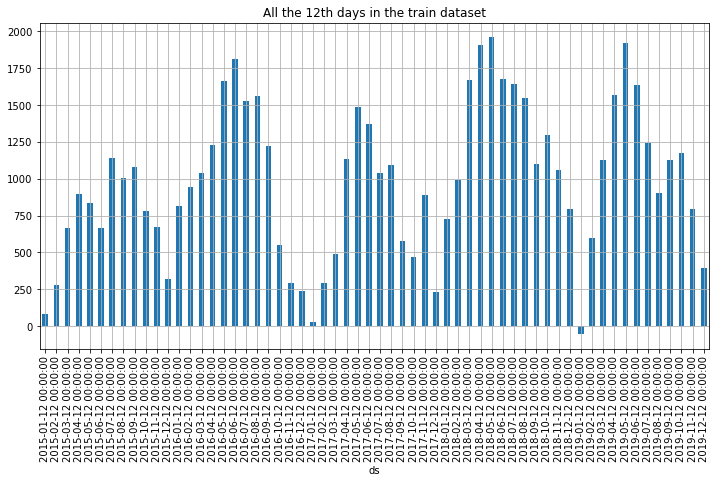

In [37]:
(pd.DataFrame({
    'delta':delta, 
    'day': delta.index.day}).
 loc[lambda df: df['day'] == 12].
 delta.
 plot(kind='bar', figsize=(12,6), grid=True))

plt.title('All the 12th days in the train dataset')
plt.show()

Very weird and consistent! Just for comparisson, lets get the 11th and 13th

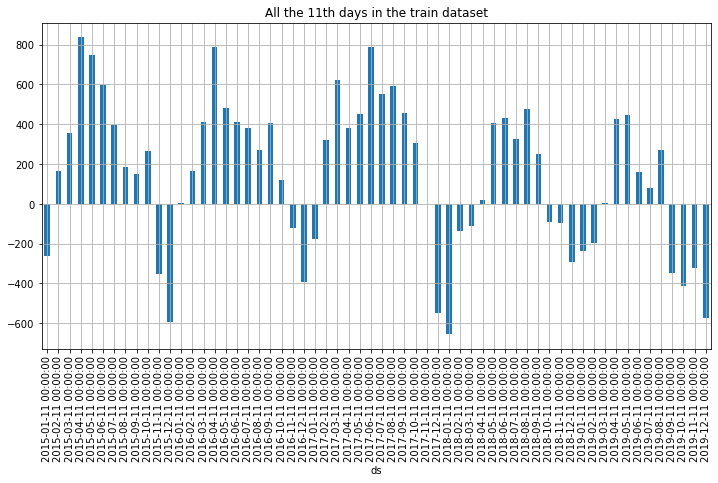

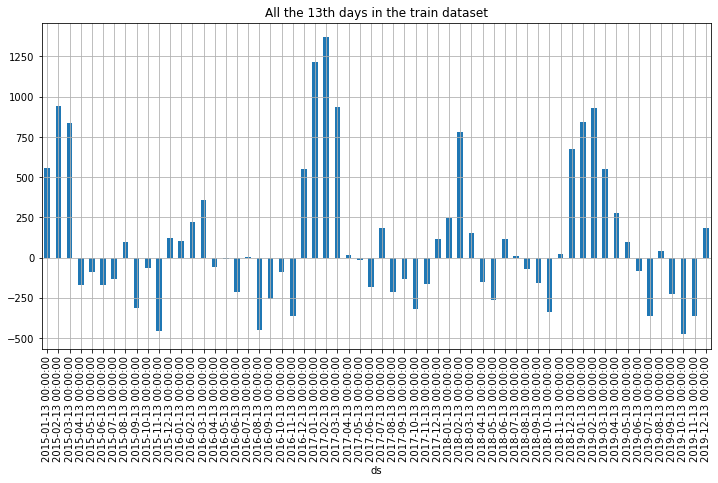

In [38]:
(pd.DataFrame({
    'delta':delta, 
    'day': delta.index.day}).
 loc[lambda df: df['day'] == 11].
 delta.
 plot(kind='bar', figsize=(12,6), grid=True))

plt.title('All the 11th days in the train dataset')
plt.show()

(pd.DataFrame({
    'delta':delta, 
    'day': delta.index.day}).
 loc[lambda df: df['day'] == 13].
 delta.
 plot(kind='bar', figsize=(12,6), grid=True))

plt.title('All the 13th days in the train dataset')
plt.show()

There seems to be a pattern - the beginning of each month (first two days + the twelth day), the energy consumption seems to be really high, followed by a week of really low consumption. 

Let us create an additional regressor to capture that pattern and see if we get better results on the test set.

In [39]:
def get_first_days(df):
    return df.assign(month_start = ((df['ds'].dt.day < 3) | (df['ds'].dt.day == 12) ).astype(int))

def get_second_week(df):
    return df.assign(second_week = ((df['ds'].dt.day > 3) & (df['ds'].dt.day < 11)).astype(int) )

In [40]:
m_cv_regressors = Prophet(
    seasonality_prior_scale=best_params['seasonality_prior_scale'], 
    changepoint_prior_scale = best_params['changepoint_prior_scale'],
    yearly_seasonality = best_params['yearly_seasonality'],
    weekly_seasonality = best_params['weekly_seasonality']

)
m_cv_regressors.add_country_holidays('BG')
m_cv_regressors.add_regressor('month_start')
m_cv_regressors.add_regressor('second_week')

m_cv_regressors.fit(train_set_prophet.pipe(get_first_days).pipe(get_second_week))


future = m_cv_regressors.make_future_dataframe(periods=365)
forecast_cv_regressors = m_cv_regressors.predict(future.pipe(get_first_days).pipe(get_second_week))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


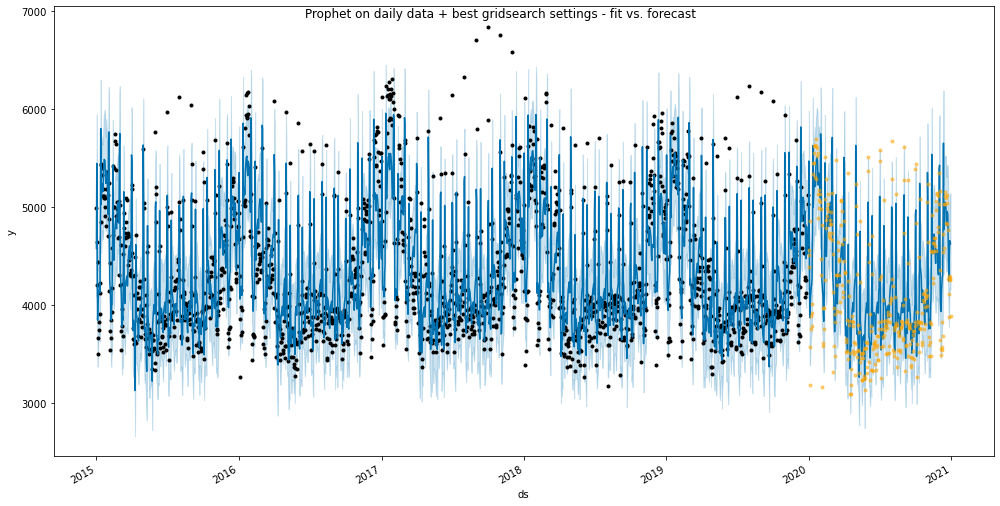

In [41]:
#Plot fit and forecast
fig, ax = plt.subplots(figsize=(14,8))
m_cv_regressors.plot(forecast_cv_regressors, ax=ax)
test_set_prophet.set_index('ds').y.plot(ax=ax, style = ".", color='orange', alpha=0.5)
plt.suptitle('Prophet on daily data + best gridsearch settings - fit vs. forecast')
plt.show()

In [42]:
#Comparing Train set and the new forecaster's errors
delta = train_set_prophet.set_index('ds').y - forecast_cv_regressors.set_index('ds').yhat.loc[:'2019-12-31']

print('Mean Error: ', delta.abs().sum()/len(delta))

Mean Error:  290.4469597364469


In [43]:
cutoffs = pd.date_range(start='2017-01-01', periods=12, freq='3M')
df_cv = cross_validation(m_cv_regressors, cutoffs = cutoffs, horizon='30 days', parallel="processes")
df_p = performance_metrics(df_cv, rolling_window=1)
print(f"Cross-Validation RMSE: {df_p.loc[0,'rmse']}")
print(f"Cross-Validation MAPE: {df_p.loc[0,'mape']}")

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023920383EB0>


Cross-Validation RMSE: 416.8380604965276
Cross-Validation MAPE: 0.06750891956220671


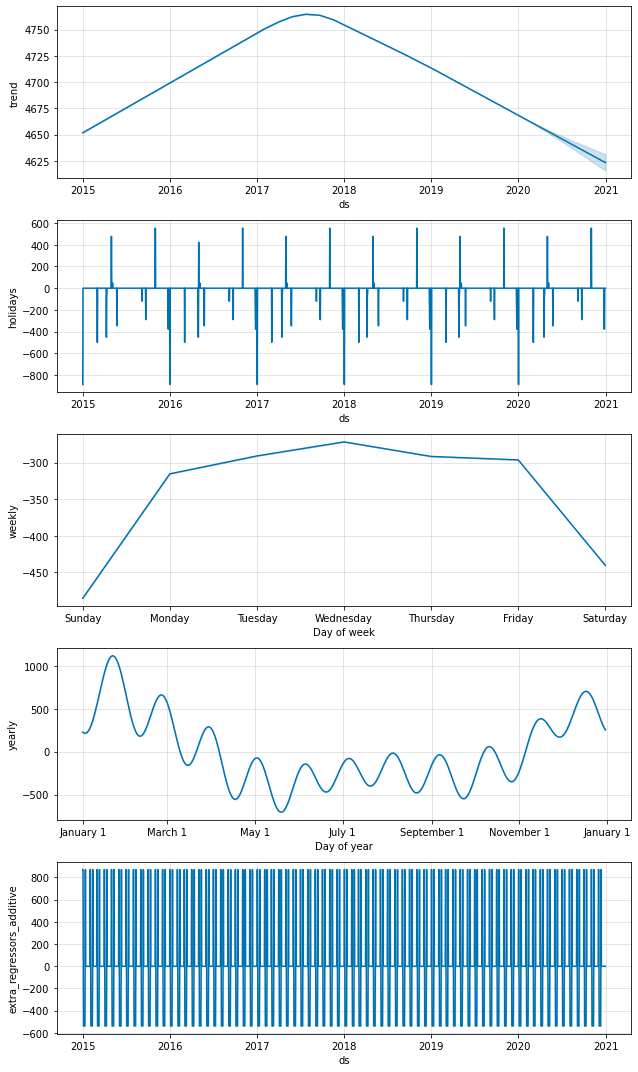

In [44]:
m_cv_regressors.plot_components(forecast_cv_regressors);

## Final comparisson

The model with the additional regressors seems to have lower RMSE and MAPE on the train set. However, the components breakdown looks weird (perhaps a new grid-search would be needed). 

It is time to compare both models (the result of the cross-validation one vs. the cross-validation + regressors) on the test set and see how the two models generalize

In [45]:
comparisson_df = pd.DataFrame({
    'y_test': test_set_prophet.set_index('ds').y.loc[:'2020-12-30'],
    'cv_only': forecast_cv.set_index('ds').yhat.loc['2020-01-01':], #Remember, the forcast files contain past yhat as well.
    'cv_and_regressors': forecast_cv_regressors.set_index('ds').yhat.loc['2020-01-01':] 
})

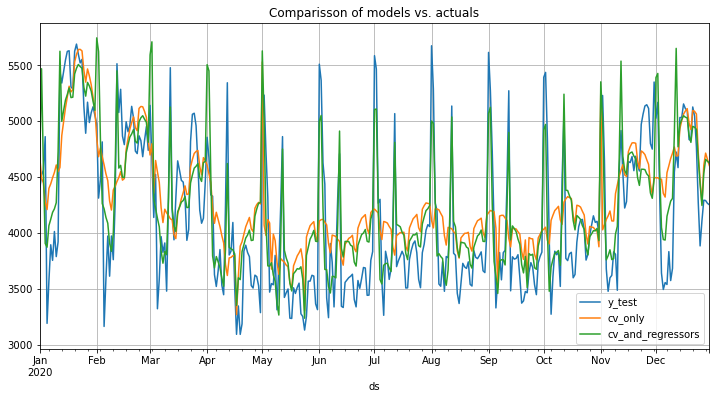

In [46]:
comparisson_df.plot(grid=True, figsize=(12,6))
plt.title("Comparisson of models vs. actuals")
plt.show()

A bit tough too see anything, lets aggregate and compare the models then.

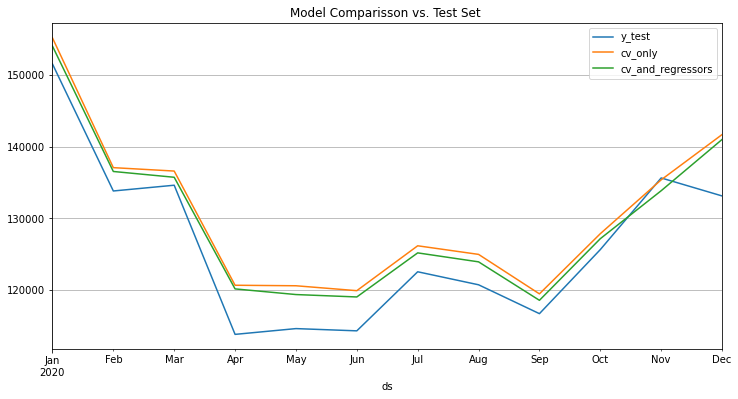

In [47]:
(comparisson_df.
 resample('MS').sum().
 plot(grid=True, figsize=(12,6)))

plt.title("Model Comparisson vs. Test Set ")
plt.show()

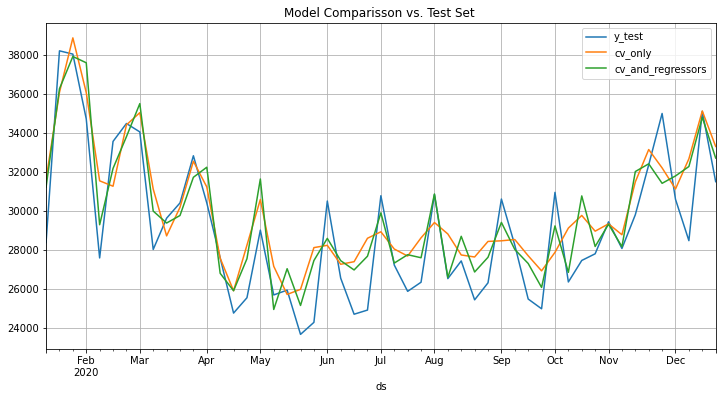

In [48]:
(comparisson_df.
 resample('W').sum().
 iloc[1:-1].
 plot(grid=True, figsize=(12,6)))

plt.title("Model Comparisson vs. Test Set ")
plt.show()

In [49]:
# Get Absolute Error comparisson
(comparisson_df.
 assign(delta_cv = lambda df: df['y_test'] - df['cv_only']).
 assign(delta_cv_regressor = lambda df: df['y_test'] - df['cv_and_regressors']).
 abs().
 loc[:,['delta_cv', 'delta_cv_regressor']].
 describe()
)

delta_cv  delta_cv_regressor
count   365.000000          365.000000
mean    406.334373          290.099582
std     314.363318          213.838003
min       6.472515            1.747460
25%     194.358497          126.354503
50%     338.806434          252.054630
75%     508.688844          399.285121
max    1726.464692         1312.466630

The model with the additional regressors seem legit. If we do another grid-search, this time with the additional regressors, we will most probably get even better results.